In [3]:
import os
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from fastai import *
from fastai.tabular import *
from fastai.vision.all import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import math 
from sklearn.metrics import mean_squared_error
import mysql.connector
import datetime

In [5]:
#Change this csv path to the correct path where you have your csv file
#Make sure you get rid of all of the spaces in this csv file - just go to the actual csv (preferrably open it in notepad, I had problems with excel)
#and click "Replace All'. You put in a space in the replace section and put nothing in the replace-with section, so it
# gets rid of all of the spaces.
#Get the data from Yahoo Finance for the last 5 years.  This csv is from this link: https://finance.yahoo.com/quote/AAPL/history?ltr=1
# I selected the "5Y" option
df = pd.read_csv('Tesla_Analysis/NasdaqTSLAData.csv')
df.head()
df2 = df.reset_index()["Close"]
df2.shape
df2.head


<bound method NDFrame.head of 0        46.051998
1        47.438000
2        46.397999
3        46.542000
4        46.076000
           ...    
1254    489.609985
1255    521.849976
1256    555.380005
1257    574.000000
1258    585.760010
Name: Close, Length: 1259, dtype: float64>

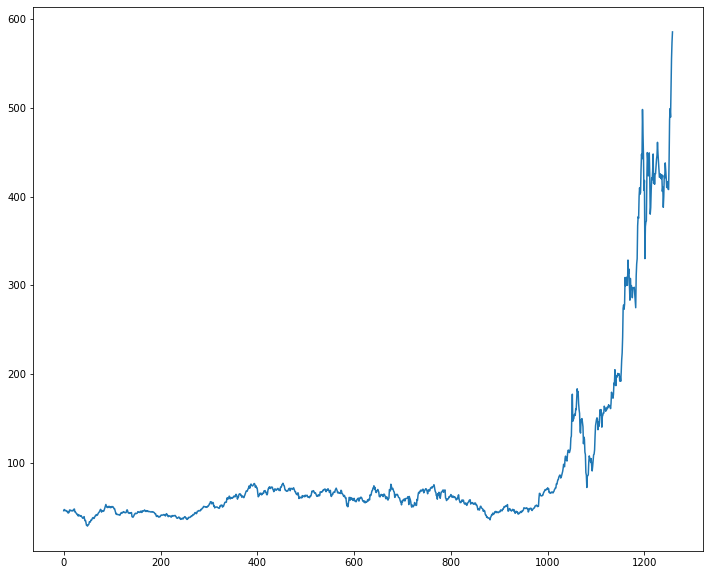

In [6]:
plt.figure(figsize = (12,10))
plt.plot(df2)

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))

In [8]:
train_split_param = 0.80
train_split = int(len(df2)*(train_split_param))
train_data, test_data = df2[0:train_split,:] , df2[train_split:,:1]
def create_series_instances(data, timestep = 1):
    inputs, outputs = [], []
    for i in range(len(data) - timestep - 1):
        input_arr = data[i : (i + timestep), 0]
        output_value = data[i + timestep, 0]
        inputs.append(input_arr)
        outputs.append(output_value)
    return np.array(inputs), np.array(outputs)

timestep = 150
x_train, y_train = create_series_instances(train_data, timestep)
x_test, y_test = create_series_instances(test_data, timestep)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [9]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (150, 1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 150, batch_size = 64, verbose = 1)

Train on 856 samples, validate on 101 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/150
856/856 [==============================] - 7s 8ms/sample - loss: 7.1072e-04 - val_loss: 0.2721
Epoch 2/150
856/856 [==============================] - 4s 5ms/sample - loss: 2.7169e-04 - val_loss: 0.2182
Epoch 3/150
856/856 [==============================] - 4s 5ms/sample - loss: 1.8579e-04 - val_loss: 0.0971
Epoch 4/150
856/856 [==============================] - 4s 5ms/sample - loss: 8.6125e-05 - val_loss: 0.0083
Epoch 5/150
856/856 [==============================] - 5s 5ms/sample - loss: 7.5325e-05 - val_loss: 0.0288
Epoch 6/150
856/856 [==============================] - 5s 5ms/sample - loss: 6.4313e-05 - val_loss: 0.0163
Epoch 7/150
856/856 [==============================] - 5s 6ms/sample - loss: 6.0758e-05 - val_loss: 0.0191
Epoch 8/150
856/856 [==============================] - 5s 5ms/sample - loss: 5.6549e-05 - val_loss: 0.0158
Epoc

856/856 [==============================] - 6s 7ms/sample - loss: 1.9021e-05 - val_loss: 0.0215
Epoch 74/150
856/856 [==============================] - 5s 6ms/sample - loss: 1.8725e-05 - val_loss: 0.0234
Epoch 75/150
856/856 [==============================] - 5s 6ms/sample - loss: 1.8005e-05 - val_loss: 0.0217
Epoch 76/150
768/856 [=========================>....] - ETA: 0s - loss: 1.5191e-05

In [ ]:
predict_train = model.predict(x_train)
predict_test = model.predict(x_test)

In [ ]:
predict_train = scaler.inverse_transform(predict_train)
predict_test = scaler.inverse_transform(predict_test)

In [ ]:
math.sqrt(mean_squared_error(y_train, predict_train))

In [ ]:
math.sqrt(mean_squared_error(y_test, predict_test))

In [ ]:
input_list = test_data[(len(test_data) - 150):]
print(len(input_list))
input_list = input_list.reshape(1, -1)
print(len(input_list))
temp = (list(input_list))[0].tolist()
print(len(temp))

In [ ]:
def predict_n_days(num_days, input_list, temp):
    output = []
    index = 0
    print(temp)
    print(len(temp))
    while(index < num_days):
        if(len(temp) <= 150):
            input_list = input_list.reshape((1,150,1))
            first_prediction = model.predict(input_list)
            temp.extend(first_prediction[0].tolist())
            output.extend(first_prediction.tolist())
            index += 1
        else:
            input_list = np.array(temp[1:])
            print(input_list)
            print(len(input_list))
            input_list = (input_list.reshape(1,-1)).reshape((1, 150, 1))
            later_prediction = model.predict(input_list)
            temp.extend(later_prediction[0].tolist())
            temp = temp[1:]
            output.extend(later_prediction.tolist())
            index += 1
    return output

output_list = predict_n_days(40, input_list, temp)
print(output_list)




In [ ]:
# new_output_list = []
# for i in range(len(output_list)):
#     new_output_list.append(output_list[i][0])

predict_df = df2.tolist()
predict_df.extend(output_list)
# predict_df.extend(output_list)
plt.plot(predict_df[1260:])


In [ ]:
predict_df =scaler.inverse_transform(predict_df).tolist()
plt.plot(predict_df)

In [ ]:
#[1260 : 1299]
#last_date = '11/17/2020'



#Now here is the database connection - change the credentials to your database on your local system. 
db = mysql.connector.connect(
	host = "localhost",
	user = "ayush",
	passwd = "[your password]",
	database = "Financial_Database"
	)


mycursor = db.cursor()

#Change the name of the table from AAPL_Predictions to new company_predictions
mycursor.execute("CREATE TABLE IF NOT EXISTS TSLA_Predictions (Date_Recorded Date, Close DECIMAL(19,6))")

In [ ]:
#Replace the values in this date attribute with the last date in your original data
#The last date in the AAPL data is 11/17/2020 - this means that since we want to predict the next 40 days,
#we want to have 11/17/2020 as our starting date before entering our predictions

date = datetime.datetime(2020,11,27,12,4,5)
#So, date = datetime.datetime(2020, your last month, your last day, x, x, x)
#Last 3 values dont matter - they are the time, but we dont consider the time
for i in range(40): 
    date += datetime.timedelta(days=1)
    prediction_index = len(df2) + i
    sql_query = "INSERT INTO TSLA_Predictions(Date_Recorded, Close) VALUES (%s, %s)"
    val_tuple = (date.date(), predict_df[prediction_index][0])
    mycursor.execute(sql_query, val_tuple)
    db.commit()